In [109]:
import uproot3
import matplotlib.pyplot as plt
import math
import numpy as np

from   matplotlib import colors

plt.style.use('seaborn-whitegrid')

# plt.rcParams["figure.figsize"]  = (25.6,9.6)
plt.rcParams["figure.figsize"]  = (20.0, 20.0)
plt.rcParams["image.origin"]    = 'lower'

In [166]:
Neta    = 96
Nphi    = 256
shape   = (Neta, Nphi)

barrel  = np.zeros(shape, dtype=float)

Ntotal = shape[0]*shape[1]
print("Total channels", Ntotal)

tower_map = np.zeros((Ntotal,2), dtype=int)


for n in range(Ntotal):
    eta = n // Nphi
    phi = n %  Nphi
    tower_map[n] =  [eta, phi]

# print(tower_map)

Total channels 24576


In [74]:
def pseudorap(p):
    pTot = math.sqrt(p[0]**2+p[1]**2+p[2]**2)
    return math.atanh(p[2]/pTot)

In [114]:
def pT(p):
    return math.sqrt(p[0]**2+p[1]**2)

In [327]:
def pTot(p):
    return math.sqrt(p[0]**2+p[1]**2+p[2]**2)

In [332]:
def phiAngle(p):
    res = 0.0
    try:
        res = math.atan(p[1]/p[0])
    except:
        print('Error', p)
    return res

In [234]:
infile = '~/data/mc/gamma_10k.root'
file   = uproot3.open(infile)

dir         = file['ttree']
p_branch    = dir['p']
Nentries    = p_branch.numentries

N_branch        = dir["N"]
nlive_branch    = dir["nlive"]
p_branch        = dir["p"]
energy_branch   = dir["energy"]

N       = N_branch.array()
nlive   = nlive_branch.array()
p       = p_branch.array()
energy  = energy_branch.array()



In [155]:
import pstats


eta_lo = 0.024
eta_hi = 1.1

total_energy    = []
etas            = []
pts             = []
ptotal          = []

for i in range(Nentries): # loop over the data sample
    etarap = pseudorap(p[i])
    if abs(etarap) < eta_lo or abs(etarap) > eta_hi: continue

    ntowers = nlive[i]
    e = energy[i]

    en = 0.0
    for nt in range(ntowers):
        en+=e[nt]

    total_energy.append(en)
    etas.append(etarap)
    pts.append(pT(p[i]))
    ptotal.append(pTot(p[i]))

#print(len(total_energy))


/tmp/ipykernel_2030/2396643572.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = axs[1,1].hist2d(etas, total_energy, bins=(100,100), norm=colors.LogNorm(1.0), cmap='plasma')


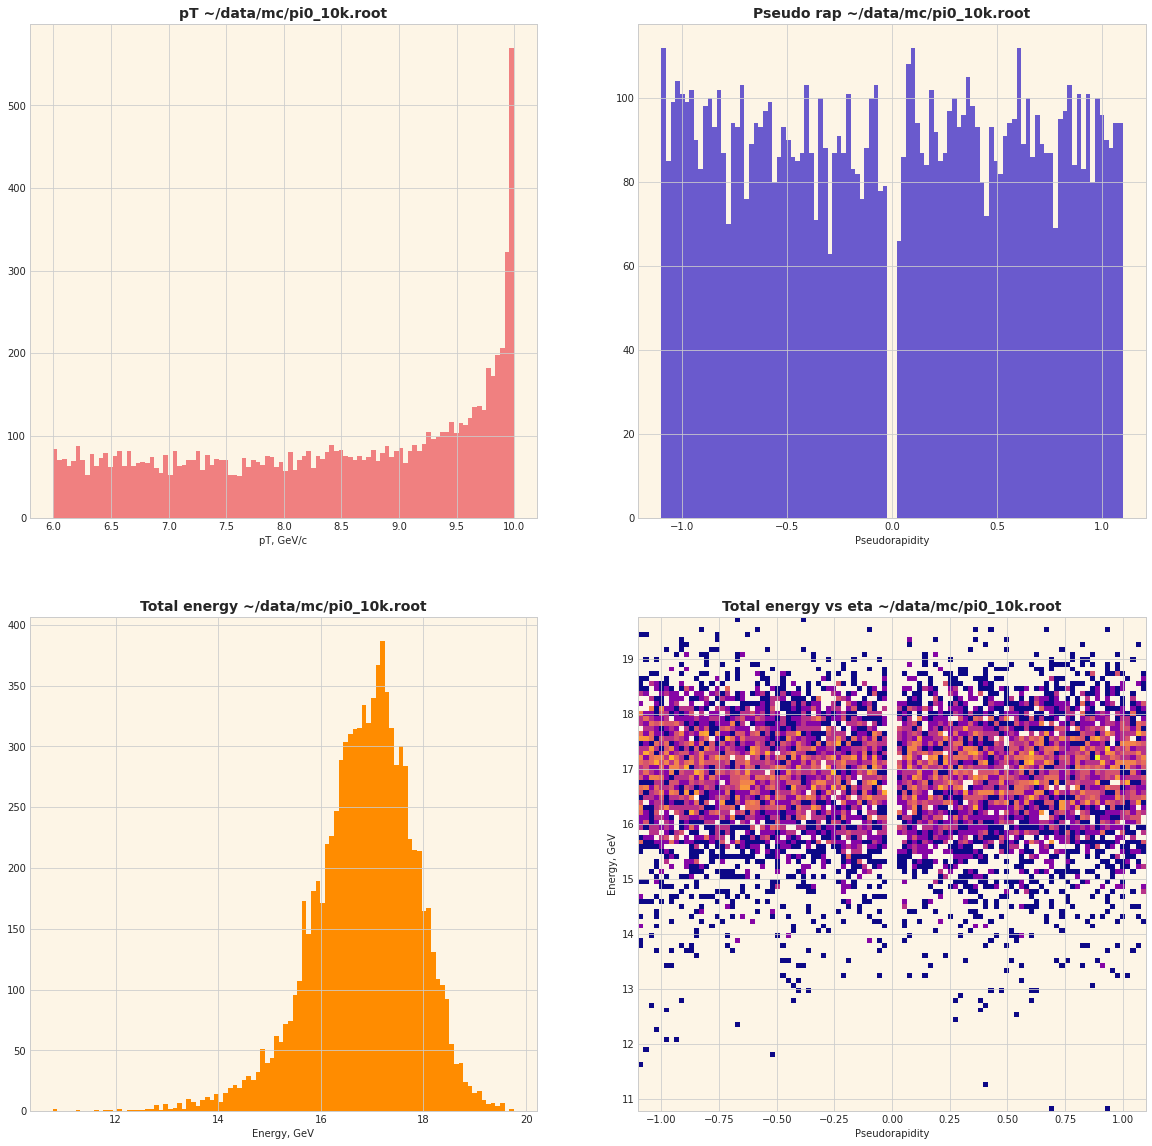

In [157]:
fig, axs = plt.subplots(2,2)

_ = axs[0,0].hist(pts, bins=100, color='lightcoral')
axs[0,0].set_title('pT '+ infile, fontsize=14, fontweight='bold')
axs[0,0].set_xlabel('pT, GeV/c')


_ = axs[0,1].hist(etas, bins=100, color='slateblue')
axs[0,1].set_title('Pseudo rap '+ infile, fontsize=14, fontweight='bold')
axs[0,1].set_xlabel('Pseudorapidity')

_ = axs[1,0].hist(total_energy, bins=100, color='darkorange')
axs[1,0].set_title('Total energy '+ infile, fontsize=14, fontweight='bold')
axs[1,0].set_xlabel('Energy, GeV')

_ = axs[1,1].hist2d(etas, total_energy, bins=(100,100), norm=colors.LogNorm(1.0), cmap='plasma')
axs[1,1].set_title('Total energy vs eta '+ infile, fontsize=14, fontweight='bold')
axs[1,1].set_xlabel('Pseudorapidity')
axs[1,1].set_ylabel('Energy, GeV')

for j in range(2):
    for k in range(2):
        axs[j,k].xaxis.set_zorder(10.0)
        axs[j,k].yaxis.set_zorder(10.0)
        axs[j,k].set_facecolor("oldlace")
        axs[j,k].grid(True)



-0.815584004648755
3795 (14, 211)
113.92389237880707 (array([13]), array([224]))
136.68112456798553 (array([14]), array([212]))
226.4418601989746 (array([14]), array([210]))
419.07715797424316 (array([13]), array([223]))
7584.782600402832 (array([14]), array([211]))


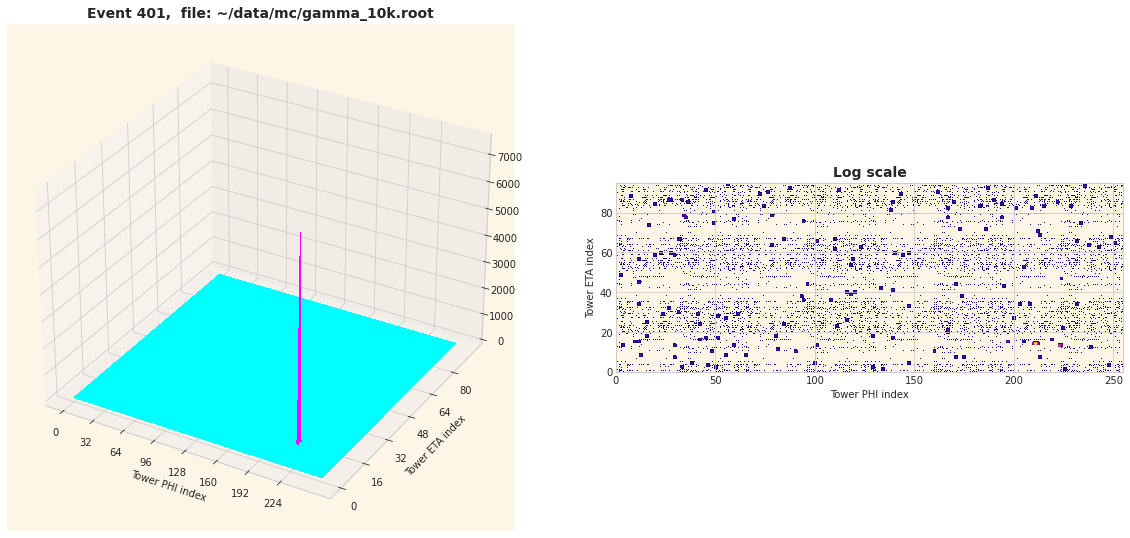

In [320]:
from matplotlib import cm
from numpy import unravel_index

plt.rcParams["figure.figsize"]  = (20.0, 10.0)
#plt.rcParams["image.origin"]    = 'lower'

fig = plt.figure()
figsize=plt.figaspect(1.0)

ax = fig.add_subplot(1, 2, 1, projection='3d')

barrel = np.zeros(shape, dtype=float)

ax.set_yticks(np.arange(0, shape[0], 16))
ax.set_xticks(np.arange(0, shape[1], 32))


i = 401

ntowers = nlive[i]
print(pseudorap(p[i]))

for nt in range(ntowers):
    my_tower = N[i][nt]    # print(myTower, e[nt])

    my_eta = tower_map[my_tower][0]
    my_phi = tower_map[my_tower][1]
    barrel[my_eta][my_phi] = 1000.0*energy[i][nt]
    # print(my_eta, my_phi, energy[i][nt])


maxlocation = unravel_index(barrel.argmax(), shape)
print(barrel.argmax(), maxlocation)

flat = barrel.flatten()
flat.sort()

for val in flat[-5:]:
    indices = np.where(barrel == val)
    print(val, indices)


X = range(256)
Y = range(96)
X, Y = np.meshgrid(X, Y)

surf = ax.plot_surface(X, Y, barrel, rstride=1, cstride=1, cmap=cm.cool, linewidth=0, antialiased=False)
ax.set_title('Event '+ str(i)+ ',  file: '+ infile, fontsize=14, fontweight='bold')
ax.set_xlabel('Tower PHI index')
ax.set_ylabel('Tower ETA index')
ax.set_facecolor("oldlace")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(barrel, extent=(0.0, 255.0, 0.0, 95.0),  norm=colors.LogNorm(10.0), cmap='plasma')
ax.set_title('Log scale', fontsize=14, fontweight='bold')
ax.set_xlabel('Tower PHI index')
ax.set_ylabel('Tower ETA index')
ax.set_facecolor("oldlace")
plt.show()



/tmp/ipykernel_2030/3889031039.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = axs[1,0].hist2d(d_phi, d_eta, bins=(51,11), range=((-25.5, 25.5), (-5.5, 5.5)), norm=colors.LogNorm(1.0), cmap='Oranges')
/tmp/ipykernel_2030/3889031039.py:68: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = axs[1,1].hist2d(d_phi, etas, bins=(51,50), range=((-25.5, 25.5), (-1.0, 1.0)), norm=colors.LogNorm(1.0), cmap='Oranges')


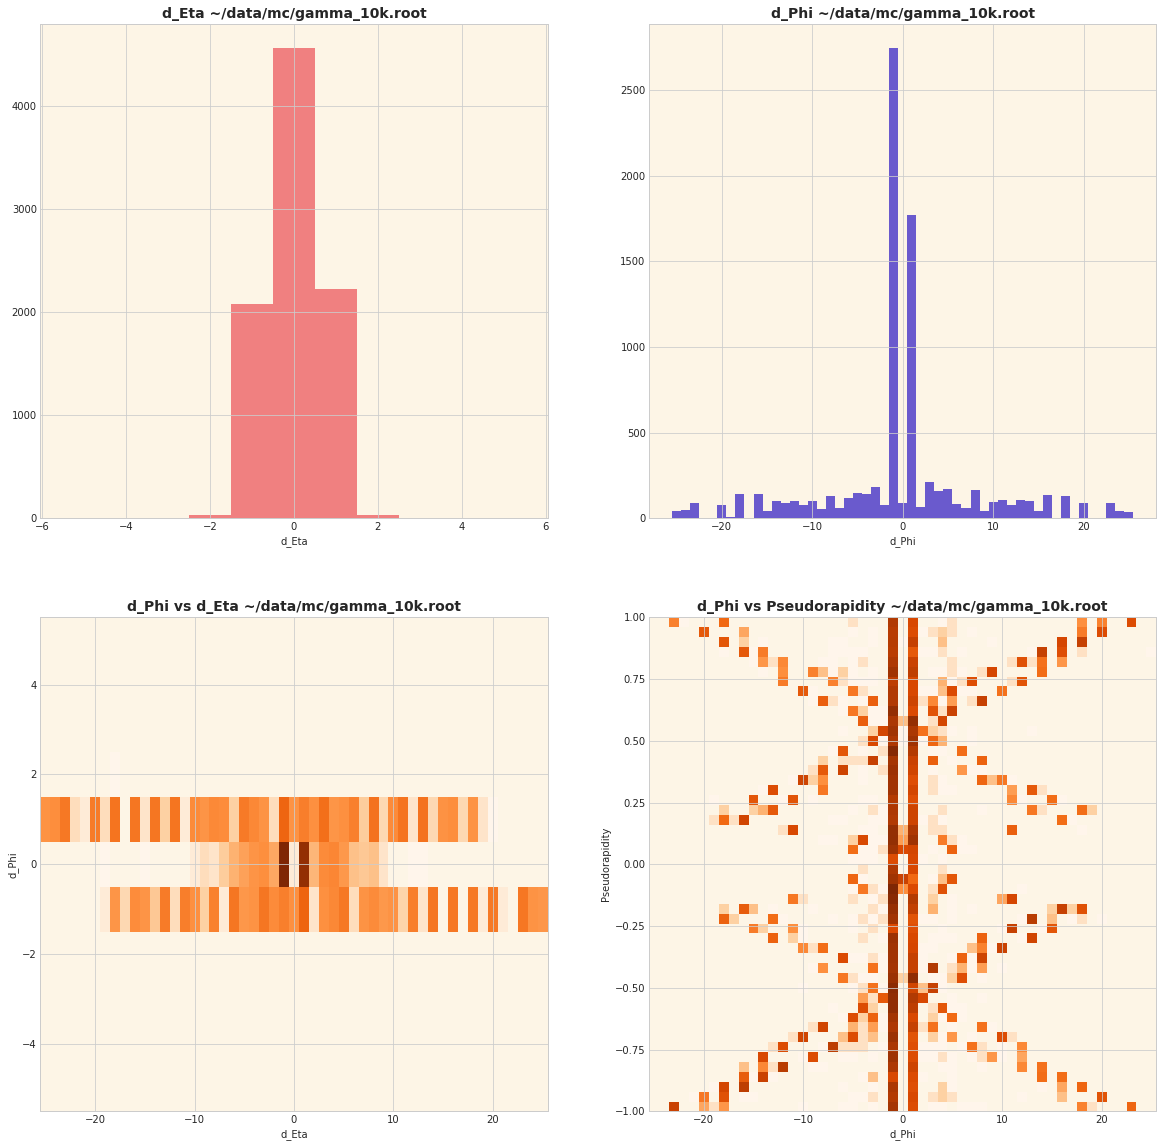

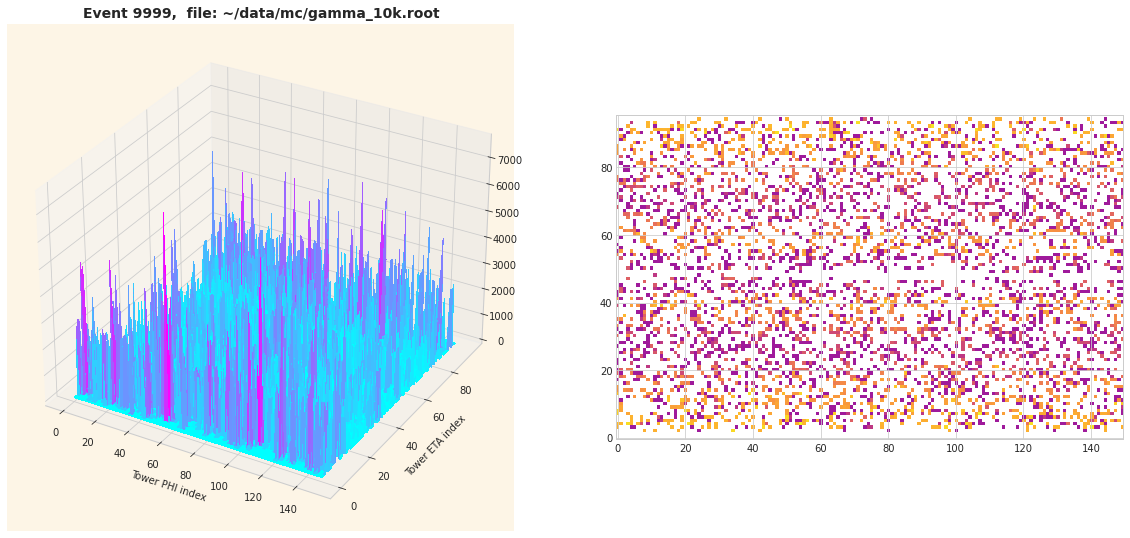

In [346]:
plt.rcParams["figure.figsize"]  = (20.0, 20.0)


barrel_phi = np.zeros(shape, dtype=int)

d_eta   = []
d_phi   = []
etas    = []

phis    = []

for i in range(Nentries): # loop over the data sample
    barrel = np.zeros(shape, dtype=float)
    etarap = pseudorap(p[i])
    if abs(etarap) < eta_lo or abs(etarap) > eta_hi: continue

    ntowers = nlive[i]

    for nt in range(ntowers):
        my_tower    = N[i][nt]    # print(myTower, e[nt])

        my_eta = tower_map[my_tower][0]
        my_phi = tower_map[my_tower][1]
        barrel[my_eta][my_phi] = 1000.0*energy[i][nt]

    flat = barrel.flatten()
    maxval = np.amax(flat)
    second =  np.partition(flat, -2)[-2]

    indices1 = np.where(barrel == maxval)
    indices2 = np.where(barrel == second)

    # print(maxval, second, indices1, indices2)


    d_eta.append(indices1[0][0] - indices2[0][0])
    d_phi.append(indices1[1][0] - indices2[1][0])


    abs_phi = abs(indices1[1][0] - indices2[1][0])
    barrel_phi[indices1[0][0],indices1[1][0]]+=100*abs_phi

    phiA = phiAngle(p[i])

    etas.append(etarap)
    phis.append(phiA)

    #for val in flat[-2:]:
    #    indices = np.where(barrel == val)
    #    print(val, indices)


fig, axs = plt.subplots(2,2)

_ = axs[0,0].hist(d_eta, bins=11, range=(-5.5, 5.5), color='lightcoral')
axs[0,0].set_title('d_Eta '+ infile, fontsize=14, fontweight='bold')
axs[0,0].set_xlabel('d_Eta')

_ = axs[0,1].hist(d_phi, bins=51, range=(-25.5, 25.5), color='slateblue')
axs[0,1].set_title('d_Phi '+ infile, fontsize=14, fontweight='bold')
axs[0,1].set_xlabel('d_Phi')

_ = axs[1,0].hist2d(d_phi, d_eta, bins=(51,11), range=((-25.5, 25.5), (-5.5, 5.5)), norm=colors.LogNorm(1.0), cmap='Oranges')
axs[1,0].set_title('d_Phi vs d_Eta '+ infile, fontsize=14, fontweight='bold')
axs[1,0].set_xlabel('d_Eta')
axs[1,0].set_ylabel('d_Phi')

_ = axs[1,1].hist2d(d_phi, etas, bins=(51,50), range=((-25.5, 25.5), (-1.0, 1.0)), norm=colors.LogNorm(1.0), cmap='Oranges')
axs[1,1].set_title('d_Phi vs Pseudorapidity '+ infile, fontsize=14, fontweight='bold')
axs[1,1].set_xlabel('d_Phi')
axs[1,1].set_ylabel('Pseudorapidity')

for j in range(2):
    for k in range(2):
        axs[j,k].xaxis.set_zorder(10.0)
        axs[j,k].yaxis.set_zorder(10.0)
        axs[j,k].set_facecolor("oldlace")
        axs[j,k].grid(True)



fig = plt.figure()
figsize=plt.figaspect(1.0)

ax = fig.add_subplot(1, 2, 1, projection='3d')


X = range(150)
Y = range(96)
X, Y = np.meshgrid(X, Y)

surf = ax.plot_surface(X, Y, barrel_phi[:, 50:200], rstride=1, cstride=1, cmap=cm.cool, linewidth=0, antialiased=False)
ax.set_title('Event '+ str(i)+ ',  file: '+ infile, fontsize=14, fontweight='bold')
ax.set_xlabel('Tower PHI index')
ax.set_ylabel('Tower ETA index')
ax.set_facecolor("oldlace")

ax = fig.add_subplot(1, 2, 2)
#ax.imshow(barrel_phi, extent=(0.0, 255.0, 0.0, 95.0),  norm=colors.LogNorm(10.0), cmap='plasma')
#ax.set_title('Log scale', fontsize=14, fontweight='bold')
#ax.set_xlabel('Tower PHI index')
#ax.set_ylabel('Tower ETA index')
#ax.set_facecolor("oldlace")
#plt.show()

ax.imshow(barrel_phi[:, 50:200], norm=colors.LogNorm(10.0), cmap='plasma')
# print(barrel_phi)
# surf = ax.plot_surface(eta, phis, d_phi, rstride=1, cstride=1, cmap=cm.cool, linewidth=0, antialiased=False)